In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Introduction 

This lab introduces the use of the fast Fourier transform for estimation
of the power spectral density and for simple filtering.  If you need a refresher or
are learning about fourier transforms for the first time,  we recommend reading
[Newman Chapter 7](http://clouds.eos.ubc.ca/~phil/docs/atsc500/pdf_files/newman_chapter7.pdf).  For a description of the Fast Fourier transform,
see [Stull Section 8.4](http://clouds.eos.ubc.ca/~phil/docs/atsc500/pdf_files/stull_section8_4.pdf) and [Jake VanderPlas's blog entry](https://jakevdp.github.io/blog/2013/08/28/understanding-the-fft/).  Another good resources is
[Numerical Recipes Chapter 12](http://clouds.eos.ubc.ca/~phil/docs/atsc500/pdf_files/numerical_recipes_fft.pdf)
(user: green, password: house)



## A simple transform

To get started assume that there is a pure tone -- a cosine wave oscillating at a frequency of 1 Hz.  Next assume that we sample that 1 Hz wave at a sampling rate of 5 Hz i.e. 5 times a second



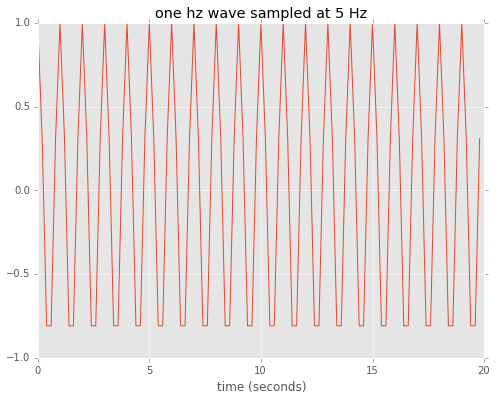

In [2]:
%matplotlib inline
#
# create a cosine wave that oscilates 20 times in 20 seconds
# sampled at  Hz, so there are 20*5 = 100 measurements in 20 seconds
#
deltaT=0.2
ticks = np.arange(0,20,deltaT)
#
#20 cycles in 20 seconds, each cycle goes through 2*pi radians
#
onehz=np.cos(2.*np.pi*ticks)
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(ticks,onehz)
ax.set_title('one hz wave sampled at 5 Hz')
out=ax.set_xlabel('time (seconds)')

Repeat, but for a 2 Hz wave

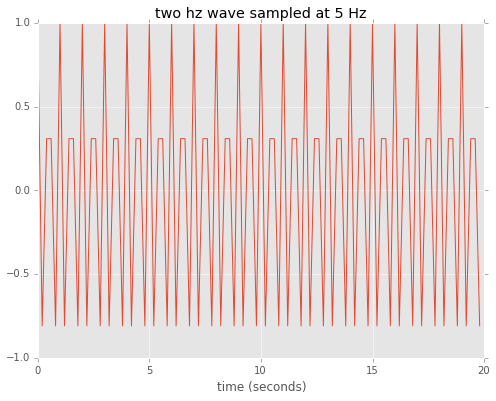

In [3]:
deltaT=0.2
ticks = np.arange(0,20,deltaT)
#
#40 cycles in 20 seconds, each cycle goes through 2*pi radians
#
twohz=np.cos(2.*2.*np.pi*ticks)
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(ticks,twohz)
ax.set_title('two hz wave sampled at 5 Hz')
out=ax.set_xlabel('time (seconds)')

Note the problem at 2 Hz,  the 5 Hz sampling frequency is too coarse to hit the top of every other
peak in the wave

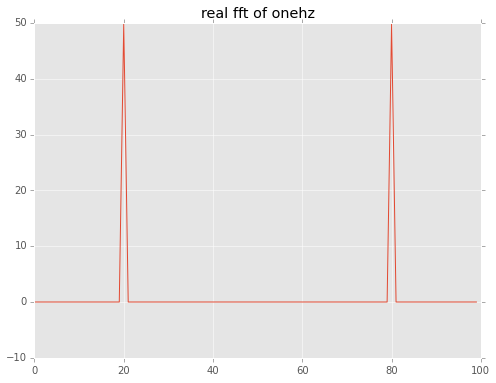

In [4]:
#now take the fft, we have 100 bins, so we alias at 50 bins, which is the nyquist frequency of 5 Hz/2. = 2.5 Hz
# so the fft frequency resolution is 20 bins/Hz, or 1 bin = 0.05 Hz
thefft=np.fft.fft(onehz)
real_coeffs=np.real(thefft)

fig,theAx=plt.subplots(1,1,figsize=(8,6))
theAx.plot(real_coeffs)
out=theAx.set_title('real fft of onehz')

The layout of the fft return value is describe in [the scipy user manual](http://docs.scipy.org/doc/scipy/reference/tutorial/fftpack.html#id9).   For reference, here is the Fourier transform calculated by numpy.fft:

$$y[k] = \sum_{n=0}^{N-1} x[n]\exp \left (- i 2 \pi k n /N \right )$$

which is the discrete version of the continuous transform (Numerical Recipes 12.0.4):

$$y(k) = \int_{-\infty}^{\infty} x(t) \exp \left ( -i k t \right ) dt$$

(Note the different minus sign convention in the exponent compared to Numerical Recipes p. 490.  It doesn't matter what you choose, as long
as you're consistent).

From the Scipy manual:

> Inserting k=0 we see that np.sum(x)  corresponds to y[0]. This term will be non-zero if we haven't removed any large scale trend in the data. For N even, the elements y[1]...y[N/2−1] contain the positive-frequency terms, and the elements y[N/2]...y[N−1] contain the negative-frequency terms, in order of decreasingly negative frequency. For N odd, the elements y[1]...y[(N−1)/2] contain the positive- frequency terms, and the elements y[(N+1)/2]...y[N−1] contain the negative- frequency terms, in order of decreasingly negative frequency.
> In case the sequence x is real-valued, the values of y[n] for positive frequencies is the conjugate of the values y[n] for negative frequencies (because the spectrum is symmetric). Typically, only the FFT corresponding to positive frequencies is plotted.

So the first peak at index 20 is (20 bins) x (0.05 Hz/bin) = 1 Hz, as expected.  The nyquist frequency of 2.5 Hz is at an index of N/2 = 50 and the negative frequency peak is 20 bins to the left of the end bin.


The inverse transform is:

$$x[n] = \frac{1}{N} \sum_{k=0}^{N-1} y]k]\exp \left ( i 2 \pi k n /N \right )$$

What about the imaginary part?  All imaginary coefficients are zero (neglecting roundoff errors)

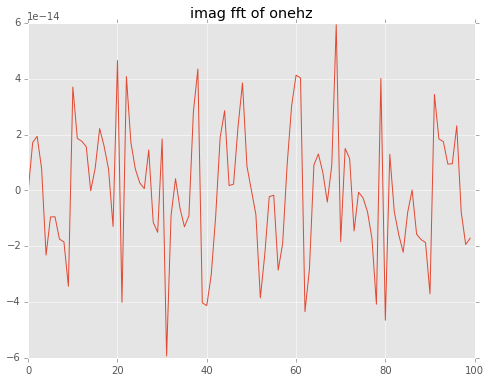

In [5]:
imag_coeffs=np.imag(thefft)
fig,theAx=plt.subplots(1,1,figsize=(8,6))
theAx.plot(imag_coeffs)
out=theAx.set_title('imag fft of onehz')

100

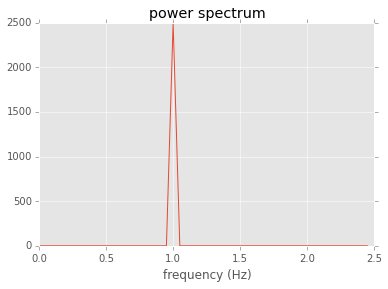

In [6]:
#now evaluate the power spectrum using Stull's 8.6.1a on p. 312

Power=np.real(thefft*np.conj(thefft))
totsize=len(thefft)
halfpoint=int(np.floor(totsize/2.))
firsthalf=Power[0:halfpoint] 


fig,ax=plt.subplots(1,1)
freq=np.arange(0,5.,0.05)
ax.plot(freq[0:halfpoint],firsthalf)
ax.set_title('power spectrum')
out=ax.set_xlabel('frequency (Hz)')
len(freq)

Check Stull 8.6.1b (or Numerical Recipes 12.0.13) which says that squared power spectrum = variance


In [7]:
print('\nsimple cosine: velocity variance %10.3f' % (np.sum(onehz*onehz)/totsize))
print('simple cosine: Power spectrum sum %10.3f\n' % (np.sum(Power)/totsize**2.))


simple cosine: velocity variance      0.500
simple cosine: Power spectrum sum      0.500



## Power spectrum of turbulent vertical velocity

In [8]:
#load data sampled at 20.8333 Hz

td=np.load('miami_tower.npz') #load temp, uvel, vvel, wvel, minutes
print('keys: ',td.keys())
print(td['description'])


keys:  ['wvel', 'vvel', 'minutes', 'temp', '__header__', 'description', 'uvel', '__globals__', '__version__']

These are measurements of atmospheric
turbulent velocity (wvel, uvel, vvel (m/s) and temperature (temp), taken
over a 30 minute period at a sampling rate of 20.8333 (125/6)
Hz. They were measured by a sonic anemometer at a height of 40 m over
suburban Miami during unstable conditions (12:01-12:31 LAT)

Total length of each timeseries is 37,500 values, so total sample time is
37000*(6/125) = 1800 seconds = 30 minutes



C:\Users\Tim\Anaconda3\lib\site-packages\IPython\kernel\__main__.py:43: RuntimeWarning: invalid value encountered in power
C:\Users\Tim\Anaconda3\lib\site-packages\matplotlib\scale.py:93: RuntimeWarning: invalid value encountered in less_equal
  mask = a <= 0.0


check Wiener-Khichine theorem for wvel

raw fft sum, full time series:     1.0337

velocity variance:     1.0337



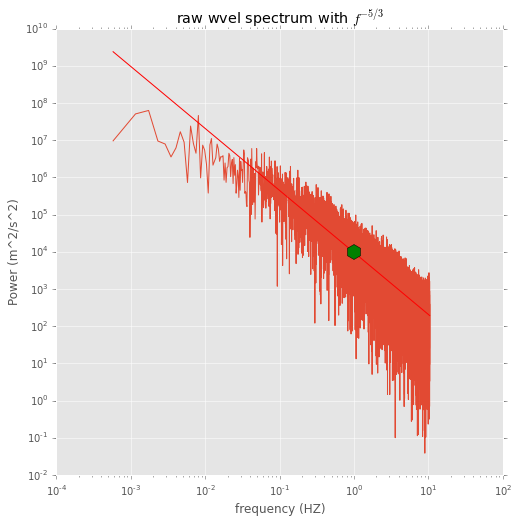

In [9]:
sampleRate=20.833
nyquistfreq=sampleRate/2.


totsize=36000
wvel=td['wvel'][0:totsize].flatten()
temp=td['temp'][0:totsize].flatten()
wvel = wvel - np.mean(wvel)
temp= temp - np.mean(temp)
flux=wvel*temp


halfpoint=np.int(np.floor(totsize/2.))
frequencies=np.arange(0,halfpoint)
frequencies=frequencies/halfpoint
frequencies=frequencies*nyquistfreq

# raw spectrum -- no windowing or averaging
#First confirm Parseval's theorem
# (Numerical Recipes 12.1.10, p. 498)

thefft=np.fft.fft(wvel)
Power=np.real(thefft*np.conj(thefft))
print('check Wiener-Khichine theorem for wvel')
print('\nraw fft sum, full time series: %10.4f\n' % (np.sum(Power)/totsize**2.))
print('velocity variance: %10.4f\n' % (np.sum(wvel*wvel)/totsize))


fig,theAx=plt.subplots(1,1,figsize=(8,8))
frequencies[0]=np.NaN
Power[0]=np.NaN
Power_half=Power[:halfpoint:]
theAx.loglog(frequencies,Power_half)
theAx.set_title('raw wvel spectrum with $f^{-5/3}$')
theAx.set(xlabel='frequency (HZ)',ylabel='Power (m^2/s^2)')
#
# pick one point the line should pass through (by eye)
# note that y intercept will be at log10(freq)=0
# or freq=1 Hz
#
leftspec=np.log10(Power[1]*1.e-3)
logy=leftspec - 5./3.*np.log10(frequencies)
yvals=10.**logy
theAx.loglog(frequencies,yvals,'r-')
thePoint=theAx.plot(1.,Power[1]*1.e-3,'g+')
thePoint[0].set_markersize(15)
thePoint[0].set_marker('h')
thePoint[0].set_markerfacecolor('g')


In [10]:
### TIM'S EDITS TO CALCULATE THE VISCOUS DISSIPATION RATE ###

# from McBean and Elliot (7), rearranging for S and taking the log: logS = log(A_i) - 5/3log(k) + 2/3log(eps)

# Assume f = k 

intercept = 1.0
intercept_index = np.where(np.abs(frequencies-1.0) == np.nanmin(np.abs(frequencies-1.0)))[0]
yvals_intercept = yvals[intercept_index][0]
# take A_i = A_w = 0.667
A_i = 0.667
epsilon = 10**(3./2.*np.log10(yvals_intercept) - np.log10(A_i)) # solve for epsilon, knowing the intercept
print("epsilon = {:.2f}".format(epsilon))

epsilon = 1404366.64


## power spectrum layout

Here is what the entire power spectrum looks like, showing positive and negative frequencies

C:\Users\Tim\Anaconda3\lib\site-packages\matplotlib\scale.py:93: RuntimeWarning: invalid value encountered in less_equal
  mask = a <= 0.0


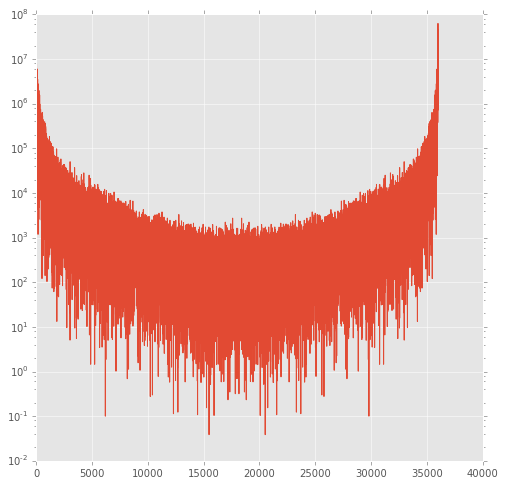

In [11]:
fig,theAx=plt.subplots(1,1,figsize=(8,8))
out=theAx.semilogy(Power)

and here is what fftshift does:

C:\Users\Tim\Anaconda3\lib\site-packages\matplotlib\scale.py:93: RuntimeWarning: invalid value encountered in less_equal
  mask = a <= 0.0


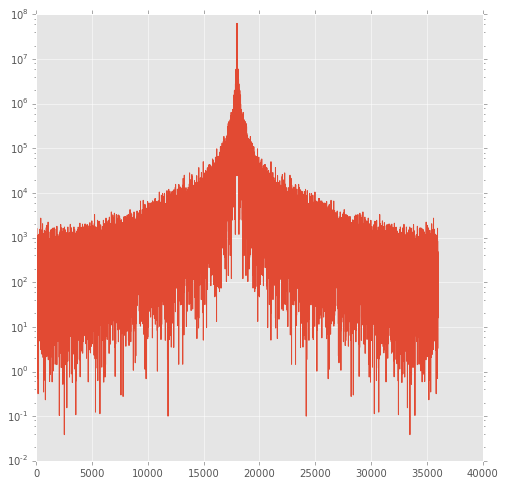

In [12]:
shift_power=np.fft.fftshift(Power)
fig,theAx=plt.subplots(1,1,figsize=(8,8))
out=theAx.semilogy(shift_power)

### Confirm that the fft at negative f is the complex conjugate of the fft at positive f

(200.427710784-150.325083995j)
(200.427710784+150.325083995j)


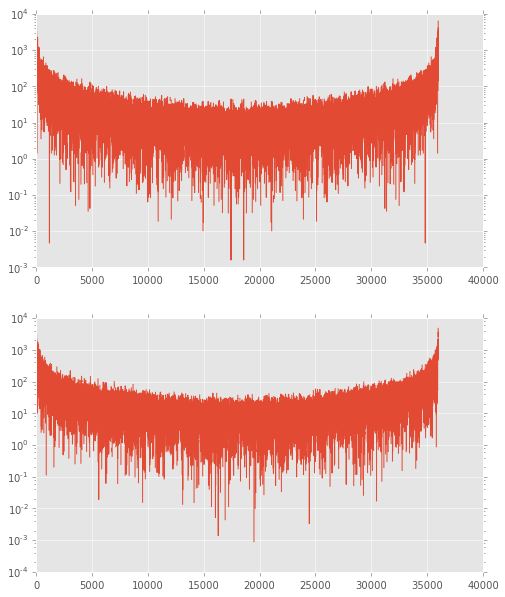

In [13]:
test_fft=np.fft.fft(wvel)
fig,theAx=plt.subplots(2,1,figsize=(8,10))
theAx[0].semilogy(np.real(test_fft))
theAx[1].semilogy(np.imag(test_fft))
print(test_fft[100])
print(test_fft[-100])

## Windowing

The FFT above is noisy, and there are several ways to smooth it.  Numerical Recipes, p. 550 has a good discussion of "windowing" which helps remove the spurious power caused by the fact that the timeseries has a sudden stop and start.
Below we split the timeseries into 25 segements of 1440 points each, fft each segment then average the 25.  We convolve each segment with a Bartlett window.




Try a windowed spectrum (Bartlett window)

sumw:      0.533


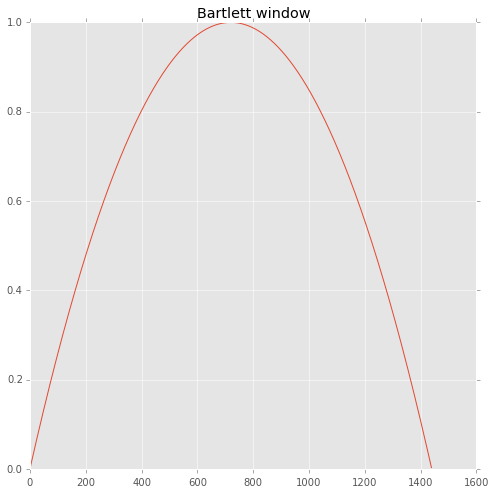

In [14]:
print('\n\n\nTry a windowed spectrum (Bartlett window)\n')
## windowing -- see p. Numerical recipes 550 for notation

def calc_window(numvals=1440):
    """
      Calculate a Bartlett window following
      Numerical Recipes 13.4.13
    """
    
    halfpoint=int(np.floor(numvals/2.))
    facm=halfpoint
    facp=1/facm

    window=np.empty([numvals],np.float)
    for j in np.arange(numvals):
        window[j]=(1.-((j - facm)*facp)**2.)
    return window

#
#  we need to normalize by the squared weights
#  (see the fortran code on Numerical recipes p. 550)
#
numvals=1440
window=calc_window(numvals=numvals)
sumw=np.sum(window**2.)/numvals
fig,theAx=plt.subplots(1,1,figsize=(8,8))
theAx.plot(window)
theAx.set_title('Bartlett window')
print('sumw: %10.3f' % sumw)

In [15]:
def do_fft(the_series,window,ensemble=25,title='title'):
    numvals=len(window)
    sumw=np.sum(window**2.)/numvals
    subset=the_series.copy()
    subset=subset[:len(window)*ensemble]
    subset=np.reshape(subset,(ensemble,numvals))
    winspec=np.zeros([numvals],np.float)

    for therow in np.arange(ensemble):
        thedat=subset[therow,:]
        thefft =np.fft.fft(thedat*window)
        Power=thefft*np.conj(thefft)
        #print('\nensemble member: %d' % therow)
        #print('\nwindowed fft sum (m^2/s^2): %10.4f\n' % (np.sum(Power)/(sumw*numvals**2.),))
        #print('velocity variance (m^2/s^2): %10.4f\n\n' % (np.sum(thedat*thedat)/numvals,))
        winspec=winspec + Power

    winspec=np.real(winspec/(numvals**2.*ensemble*sumw))
    return winspec

## Compare power spectra for wvel, theta, sensible heat flux

### start with wvel

In [16]:
winspec=do_fft(wvel,window)
sampleRate=20.833
nyquistfreq=sampleRate/2.
halfpoint=int(len(winspec)/2.)
averaged_freq=np.linspace(0,1.,halfpoint)*nyquistfreq   
winspec=winspec[0:halfpoint]

C:\Users\Tim\Anaconda3\lib\site-packages\IPython\kernel\__main__.py:10: RuntimeWarning: invalid value encountered in power
C:\Users\Tim\Anaconda3\lib\site-packages\matplotlib\scale.py:93: RuntimeWarning: invalid value encountered in less_equal
  mask = a <= 0.0


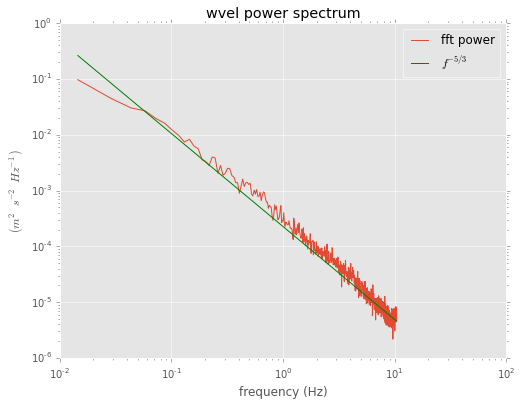

In [17]:
def do_plot(the_freq,the_spec,title=None,ylabel=None):
    the_freq[0]=np.NaN
    the_spec[0]=np.NaN
    fig,theAx=plt.subplots(1,1,figsize=(8,6))
    theAx.loglog(the_freq,the_spec,label='fft power')
    if title:
        theAx.set_title(title)
    leftspec=np.log10(the_spec[int(np.floor(halfpoint/10.))])
    logy=leftspec - 5./3.*np.log10(the_freq)
    yvals=10.**logy
    theAx.loglog(the_freq,yvals,'g-',label='$f^{-5/3}$')
    theAx.set_xlabel('frequency (Hz)')
    if ylabel:
        out=theAx.set_ylabel(ylabel)
    out=theAx.legend(loc='best')
    return theAx

labels=dict(title='wvel power spectrum',ylabel='$(m^2\,s^{-2}\,Hz^{-1})$')
ax=do_plot(averaged_freq,winspec,**labels)
 

C:\Users\Tim\Anaconda3\lib\site-packages\numpy\polynomial\polynomial.py:1383: RankWarning: The fit may be poorly conditioned
  warnings.warn(msg, pu.RankWarning)


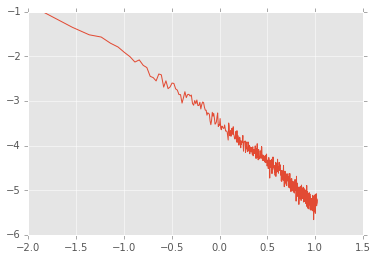

In [18]:
p = np.polynomial.polynomial.polyfit(np.log10(averaged_freq), np.log10(winspec), 1)
plt.plot(np.log10(averaged_freq),np.log10(winspec))

C:\Users\Tim\Anaconda3\lib\site-packages\IPython\kernel\__main__.py:10: RuntimeWarning: invalid value encountered in power
C:\Users\Tim\Anaconda3\lib\site-packages\matplotlib\scale.py:93: RuntimeWarning: invalid value encountered in less_equal
  mask = a <= 0.0


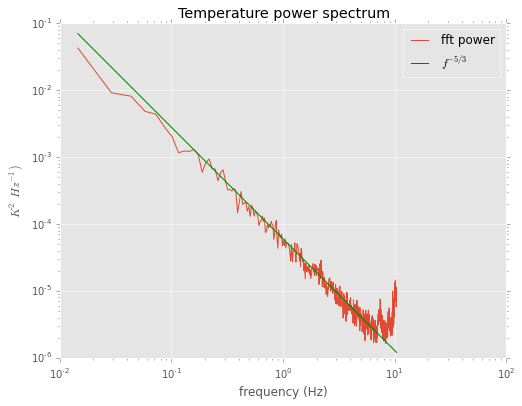

In [19]:
winspec=do_fft(temp,window)
winspec=winspec[0:halfpoint]
labels=dict(title='Temperature power spectrum',ylabel='$K^{2}\,Hz^{-1})$')
ax=do_plot(averaged_freq,winspec,**labels)

C:\Users\Tim\Anaconda3\lib\site-packages\IPython\kernel\__main__.py:10: RuntimeWarning: invalid value encountered in power
C:\Users\Tim\Anaconda3\lib\site-packages\matplotlib\scale.py:93: RuntimeWarning: invalid value encountered in less_equal
  mask = a <= 0.0


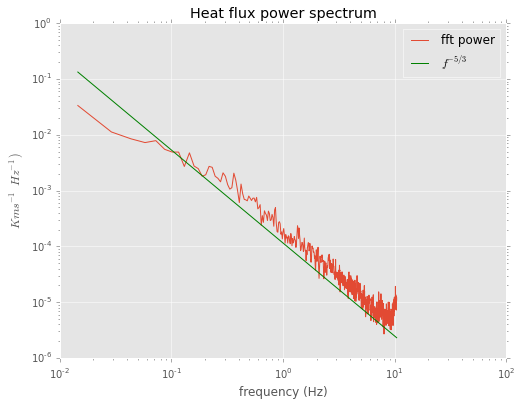

In [20]:
winspec=do_fft(flux,window)
winspec=winspec[0:halfpoint]
labels=dict(title='Heat flux power spectrum',ylabel='$K m s^{-1}\,Hz^{-1})$')
ax=do_plot(averaged_freq,winspec,**labels)

## Filtering

We can also filter our timeseries by removing frequencies we aren't interested in. Numerical Recipes discusses the approach on page 551.  For example, suppose we want to filter all frequencies higher than 0.5 Hz from the vertical velocity data.

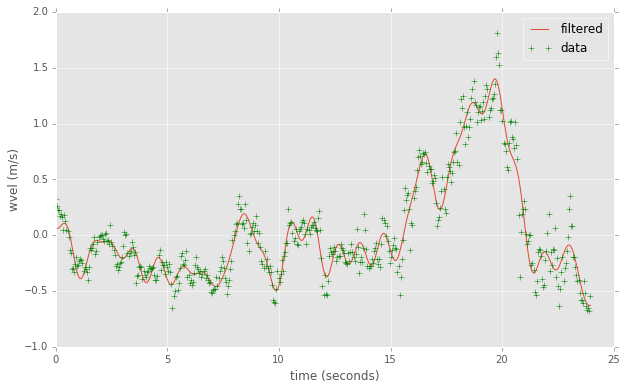

In [21]:
wvel= wvel - np.mean(wvel)
thefft=np.fft.fft(wvel)
totsize=len(thefft)
samprate=20.8333 #Hz
the_time=np.arange(0,totsize,1/20.8333)
freq_bin_width=samprate/(totsize*2)
half_hz_index=int(np.floor(0.5/freq_bin_width))
filter_func=np.zeros_like(thefft,dtype=np.float64)
filter_func[0:half_hz_index]=1.
filter_func[-half_hz_index:]=1.
filtered_wvel=np.real(np.fft.ifft(filter_func*thefft))
fig,ax=plt.subplots(1,1,figsize=(10,6))
numpoints=500
ax.plot(the_time[:numpoints],filtered_wvel[:numpoints],label='filtered')
ax.plot(the_time[:numpoints],wvel[:numpoints],'g+',label='data')
ax.set(xlabel='time (seconds)',ylabel='wvel (m/s)')
out=ax.legend()